# Simple Droneport Traffic Control system

Solving with dynamic programming.

## Classes
Classes are based on standard versions in Droneport Commander library, however, without the MAVLink connectivity layer.

In [1]:
from orchestrator_object import Battery, Drone, Droneport
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta

## Generate drones and ports

In [2]:
# params for generator
n_drones = 6  # no. of drones
samples = 50  # no. of mission waypoints
size_map = 1000  # size of square map
min_speed = 4  # minimum speed of generated drone
var_speed = 2  # variable value of speed
min_ftime = 15*60  # minimum flight time
var_ftime = 5*60  # variable flight time
min_cap = 0.8  # minimum battery capacity
var_cap = 0.2  # variable battery capacity
min_r = 300  # minimum radius of elliptical mission
var_r = 200  # minimum radius of elliptical mission

battery_id = 300

In [3]:
# get random drones
drones = []
for i in range(n_drones):
    battery_id = battery_id + 1
    drones.append(Drone(target_system=i+1, battery=Battery(id=battery_id, current_cap=min_cap+var_cap*np.random.random()),
                        location=size_map*(np.random.random((1, 2))-0.5),
                        max_speed=min_speed+var_speed*np.random.random(),
                        max_flight_time=min_ftime+var_ftime*np.random.random()))
    # init mission and time plan
    drones[-1].gen_circ_rand_mission(samples, min_r, var_r)

In [4]:
n_ports = 4  # no. of Droneport platforms
n_slots = 8  # no. of battery charging slots in Droneport platforms
port_loc_scale = 0.5  # scale for position of platform
locations = port_loc_scale*size_map * \
    np.array([[1, -1], [-1, -1], [-1, 1], [1, 1], [0, 0]]
             )  # x-y coordinatex of dronports

# get random Droneport platforms
ports = []
for i in range(n_ports):
    batteries = []
    # get fully loaded batteries
    for b in range(n_slots):
        battery_id = battery_id + 1
        batteries.append(Battery(id=battery_id))
    ports.append(Droneport(target_system=i+201, batteries=batteries,
                           location=locations[i, :],slots=n_slots))

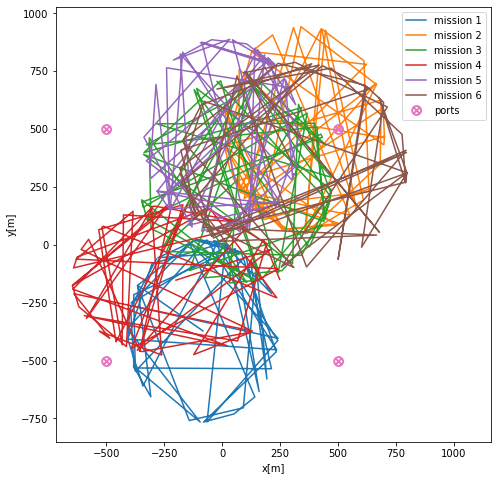

In [36]:
# draw map
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
drone_line = []
for drone in drones:
    #plt.plot(drone.location[0, 0], drone.location[0, 1], 'x')
    line, = plt.plot(drone.mission_items[:, 0], drone.mission_items[:, 1], label=f"mission {drone.id}")
    drone_line.append(line)
    
line, = plt.plot(locations[:n_ports, 0], locations[:n_ports, 1], marker=r'$\bigotimes$', linestyle='None', markersize = 10.0, label="ports")
drone_line.append(line)
plt.axis('square')
plt.xlabel('x[m]')
plt.ylabel('y[m]')
plt.legend(handles = drone_line)
#plt.title('Map with drone mission and Droneport locations')
import tikzplotlib
plt.savefig('map.png', dpi=300)
tikzplotlib.save("map.tex")
plt.show()

## Find solution with A*

In [6]:
from astar import *

In [7]:
# additional variables to init the problem

# mission progress
start = np.zeros(n_drones, dtype=int)
# every mission is completed
end = np.zeros(n_drones, dtype=int)
for drone in drones:
    end[drone.id-1] = drone.mission_count-1

# calc mission SEQ:
n_seq = 0
max_seq = 0
for drone in drones:
    n_seq = n_seq + drone.mission_count
    if drone.mission_count > max_seq:
        max_seq = drone.mission_count
        
# what nodes do we search + costs and time intervals
actions = -1*np.ones((n_ports*n_seq, 3), dtype=int)
actions_cost = -1*np.ones((n_drones, n_ports, max_seq))
actions_time = -1*np.ones((n_drones, n_ports, max_seq))
k = 0
for drone in drones:
    for port in ports:
        soc, time = drone.soc_and_time2point(port.location)
        for i in range(drone.mission_count):
            actions[k, :] = [drone.id, port.id, i]
            actions_cost[drone.id-1, port.id-201, i] = soc[i]
            actions_time[drone.id-1, port.id-201, i] = time[i]
            k = k+1

In [8]:
# find solution
path = astar(drones, ports, start, end, actions, actions_cost, actions_time)

In [34]:
# extract solution
if path is not None:
    print("plan:")
    for point in path[1:]: # first node is without action
        print(point.action)

if path is not None:
    print("schedule:")
    for window in path[-1].schedule:
        print(window)
        
    print("mission time:")
    for drone in drones:
        print(f"original: {timedelta(seconds = (drone.time_plan[-1,0]))}, final: {timedelta(seconds = (path[-1].missions_time[drone.id-1][-1,0]))}, difference: {timedelta(seconds = (path[-1].missions_time[drone.id-1][-1,0]-drone.time_plan[-1,0]))}")
        

plan:
[  4 202  21]
[  6 204  23]
[  4 202  39]
[  3 204  14]
[  3 204  30]
[  6 203  37]
[  5 203  18]
[  2 204  15]
[  2 204  24]
[  5 204  34]
[  1 201  13]
[  1 201  31]
[  1 201  36]
[  3 201  37]
[  2 201  31]
schedule:
[1, 557.1365253661497, 737.1365253661497]
[3, 664.5650398420316, 844.5650398420316]
[1, 1311.0757900325143, 1491.0757900325143]
[3, 443.69909682101104, 623.699096821011]
[3, 1332.8737145515017, 1512.8737145515017]
[2, 1355.0376993093714, 1535.0376993093714]
[2, 622.9172497139557, 802.9172497139557]
[3, 764.8822453800207, 944.8822453800207]
[3, 1493.377924865176, 1673.377924865176]
[3, 1348.8145008464412, 1528.8145008464412]
[0, 572.014173595323, 752.014173595323]
[0, 1367.6304607325528, 1547.6304607325528]
[0, 1981.5407948442933, 2161.5407948442935]
[0, 1841.0973758353002, 2021.0973758353002]
[0, 2054.8235288396913, 2234.8235288396913]
mission time:
original: 0:34:48.251912, final: 0:45:30.359720, difference: 0:10:42.107809
original: 0:34:26.566490, final: 0:46:49